# Analysis and Prediction of Donald Trump's Twitter Post
## A sentiment analysis on Trump's Tweets with multiple NLP tools
#### Author
* Dinglyu Feng

The 2020 US Presidential Election was just ended.This year we've all witnessed an unique Election during the time of Covid-19 with mail-in ballots. Donlad Trump as one of the most controversial presidents in the United States is known for his “Twitter Politics”. He has posted many tweets every day during his presidency and many of them immediately became "breaking news" on the internet. In this project, we want to explore the secret behind Donald Trump's Twitter post and do some deep analysis about them.

## Table of Content
0. Preliminary Setup

    
1. Data Construction

    1.1. Data Collection
    
    1.2. Data Cleaning


2. Exploratory Data Analysis

    2.1. Basic Statistic
    
    2.2. Sources


3. NLP Analysis

    3.1. N-Gram Analysis
    
    3.2. Sentiment Analysis
    
    3.3. Tableau Data Visualization


4. Stock Market Analysis

    4.1. Data Collection
    
    4.2. Model


This is a public project on Github. And you can find the newest version here: https://github.com/Evergreen-RX78/Econ323-NLP.git

Disclaimer: This project consisting of the analysis of Donald Trump's Tweets is only for academic purpose. It does not contain any author or organization's political perspectives nor is it trying to cause conflict among people with different political views.

### Preliminary Setup
This projecct is ran on Jupyter Notebook with Python 3.7

Before start, we install necessary packages and import them into the project:

(In order for the project to run on your system, please ensure that you've pip install all the package below)

In [1]:
# For Data collection
import tweepy as tw
import yfinance as yf

# For Data processing and ML
import numpy as np
import pandas as pd
import unicodedata
import re

# For NLP
import nltk
from textblob import TextBlob as tb

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# For Visualization
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

## Data Construction
### 1. Data Collectoin

In order to do the sentiment analysis, the first thing we need to do is to get all Trump's tweets into a dataset.

There are many python scrapping packages that can do the job. A very convenient one is call [GetOldTweets3](https://pypi.org/project/GetOldTweets3/). It's straight forward to use and doesn't require Twitter API login. However, due to a recent change on Twitter API, this package will return error message as Twitter has closed a search endpoint on their side. 

Thus, we use [Tweepy](https://www.tweepy.org/) instead, which is also a convenient scrapping package. It actually have more functions than GOT3 but its ability of getting large number of old tweets is slightly weaker.

To use Tweepy, we will need a Twitter API. It can be registered on Twitter Developer platform.

After registering your project, you will get a set of credential that need to be put in the code.

It looks like this:

In [2]:
#consumer_key = 'xxxxxx'
#consumer_secret = 'xxxxxx'
#access_token = 'xxxxxx'
#access_token_secret = 'xxxxxx'

Then we run the authentication code, which helps connect to the API.

In [3]:
"""
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth)
"""
;

''

After that, we use the following code to scrap all the tweets Trump has ever posted and put them together into a CSV file.

In [4]:
"""
# Scrapping tweets from Twitter
tweet = api.user_timeline(screen_name = "realDonaldTrump", count=200, include_rts = False,tweet_mode = 'extended')
tweets = []
tweets.extend(tweet)
oldest_id = tweet[-1].id

while True:
    tweet = api.user_timeline(screen_name = "realDonaldTrump", count=200, include_rts = False, max_id = oldest_id - 1,tweet_mode = 'extended')
    if len(tweet) == 0:
        break
    oldest_id = tweet[-1].id
    tweets.extend(tweet)

# Save all data into CSV
tweet_set = [[tweet.id_str, 
              tweet.full_text.encode("utf-8").decode("utf-8")
              tweet.favorite_count, 
              tweet.retweet_count, 
              tweet.created_at,] 
             for idx,tweet in enumerate(tweets)]
df = pd.DataFrame(tweet_set,columns=["id","text",favorites","retweets", "date"])
df.to_csv('trump_tweets.csv',index=False)
"""
;

''

Normally you should run the above code with your real API credential to get the most up to date Tweets from Twitter. However, you may notice the above code are commented out. This is because as a public project, I won't be able to show my API credentials for information safety purpose.

Instead, all the Twitter datas were collected and transformed into a dataset, which was saved in a csv file locally. We will directly read it with pandas on notebook so that this project can continue.

In [5]:
raw_tw = pd.read_csv('trump_tweets.csv')

In [6]:
raw_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55090 entries, 0 to 55089
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         55090 non-null  int64 
 1   text       55090 non-null  object
 2   isRetweet  55090 non-null  object
 3   isDeleted  55090 non-null  object
 4   device     55090 non-null  object
 5   favorites  55090 non-null  int64 
 6   retweets   55090 non-null  int64 
 7   date       55090 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.3+ MB


In [7]:
raw_tw.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59


### 2. Data Cleaning
Next we want to clean the data to get a tidy dataset that we can use.

Original tweets include many special components like hyperlinks and emojis that can't be easily analyzed by machine. We use following code to clean the text and output clean tweets that only includes alphabetical characters, regular symbols and numbers.

In [8]:
def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())
clean_tw = raw_tw
clean_tw["text"] = raw_tw['text'].apply(lambda x: clean_tweet(x))

In [9]:
clean_tw.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT Herridge READ Letter to surveillance court ...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT Very friendly telling of events here about ...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59


Furthermore, we sort all tweets by date. We also delete all the irrelevant column that don't have impact on the analysis such as data id and deletion info.

Although Trump was already a well known person a long time ago, the view and impact of his tweets have significantly increased after he was elected as the 45th US President. As he transitioning from a businessman to a political figure, his tweets have more weight on affecting the stock market as well. In this analysis, we want to focus on exploring his tweets after he was known politically. Thus, we only keep his tweets starting on 2016-02-01 (approximate time that he started rallying for the Election) and drop all tweets before that date.

In [10]:
clean_tw.sort_values("date",inplace=True)
tw = clean_tw.drop(clean_tw[clean_tw['date']<"2016-02-01"].index).drop(["id", "isDeleted"],axis=1)
tw.head(5)

,text,isRetweet,device,favorites,retweets,date
41318,Join us CaucusForTrump11am WATERLOO CEDER RAPIDS,f,Twitter for iPhone,4167,1640,2016-02-01 02:51:22
41317,It all begins today WE WILL FINALLY TAKE OUR C...,f,Twitter for Android,17571,7105,2016-02-01 13:25:20
41316,RT Sat down w here in Iowa Talked God late nig...,t,Twitter Web Client,0,852,2016-02-01 20:35:46
41315,RT CEDAR RAPIDS TRUMP S DAUGHT IVANKA I can ju...,t,Twitter Web Client,0,1384,2016-02-01 20:53:10
41303,RT VoteTrump2016 a real leader that truly care...,t,Twitter Web Client,0,1500,2016-02-02 07:33:38


Because an original tweet and a retweet are written by differetn people, they tend to have differnt tones and attitudes. Mixing them together might disturb future sentiment analysis. We take out all tweets that are retweeted and keep only tweets that are written by Trump. The original dataset is named "tw" while the new dataset with only original tweets is named "self_tw". Both of them will be used for future analysis.

In [11]:
self_tw = tw[~tw["isRetweet"].isin(["t"])]
self_tw.head()

,text,isRetweet,device,favorites,retweets,date
41318,Join us CaucusForTrump11am WATERLOO CEDER RAPIDS,f,Twitter for iPhone,4167,1640,2016-02-01 02:51:22
41317,It all begins today WE WILL FINALLY TAKE OUR C...,f,Twitter for Android,17571,7105,2016-02-01 13:25:20
41314,My experience in Iowa was a great one I starte...,f,Twitter for Android,16820,4340,2016-02-02 16:03:21
41313,Because I was told I could not do well in Iowa...,f,Twitter for Android,12001,3325,2016-02-02 16:14:24
41312,The media has not covered my long shot great f...,f,Twitter for Android,10045,3030,2016-02-02 16:29:05


## Exploratory Data Analysis
Before we start working on NLP and Machine Learning model, we want to first briefly explore the dataset.

### 1. Basic statistics
Now we have a large dataset in hand and the first thing that is interesting to look at is some extreme values.

We want to find the tweets with most likes and most retweets and see if there's any correlation between them.

In [12]:
max_fav = np.max(tw['favorites'])
max_rt  = np.max(tw['retweets'])

fav = tw[tw.favorites == max_fav].index[0]
rt  = tw[tw.retweets == max_rt].index[0]

print("The tweet with most likes is: \n{}".format(tw['text'][fav]))
print("Number of likes: {}".format(max_fav))
print("")
print("The tweet with more retweets is: \n{}".format(tw['text'][rt]))
print("Number of retweets: {}".format(max_rt))

The tweet with most likes is: 
Tonight and I tested positive for COVID 19 We will begin our quarantine and recovery process immediately We will get through this TOGETHER
Number of likes: 1869706

The tweet with more retweets is: 
Tonight and I tested positive for COVID 19 We will begin our quarantine and recovery process immediately We will get through this TOGETHER
Number of retweets: 408866


It's not surprising to find both extrme values are the one that Trump announce he was tested positive for Covid-19.

We further plot these two datas on a graph to show the trend in change of interaction level. The interactions with his tweets gradually increase as it appraoched the time of Election.

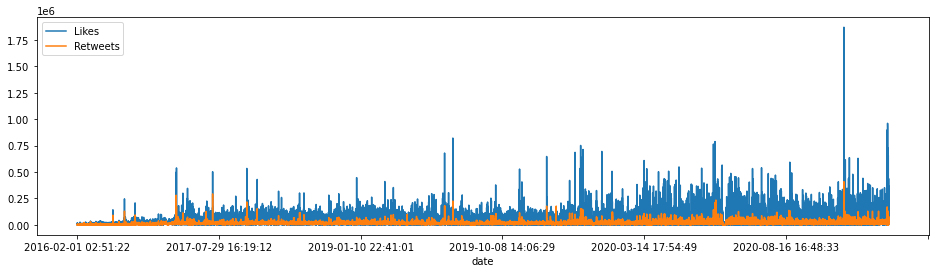

In [13]:
favs = pd.Series(tw['favorites'].values, index=tw['date'])
rets = pd.Series(tw['retweets'].values, index=tw['date'])
favs.plot(figsize=(16,4), label="Likes", legend=True);
rets.plot(figsize=(16,4), label="Retweets", legend=True);

### 2. Sources

Here we are making a list of all the devices that have been used to write a "Trump's Tweets". The following pie charts show the percentage of devic that all the tweets are sent from. While there're many articles suspecting that maybe not all of these tweets were written by Trump himself, we still choose to keep all of them, as the main purpose of this analysis is not to detect the real author of the tweets. Despite who the authors are, Trump's tweets are likely to have similar impact among readers.

In [14]:
sources = []
for source in tw['device']:
    if source not in sources:
        sources.append(source)
print("Device the tweet is written:")
for source in sources:
    print("* {}".format(source))

Device the tweet is written:
* Twitter for iPhone
* Twitter for Android
* Twitter Web Client
* Twitter Web App
* Instagram
* Twitter Ads
* Twitter for iPad
* Twitter Media Studio
* TweetDeck
* Periscope
* Media Studio


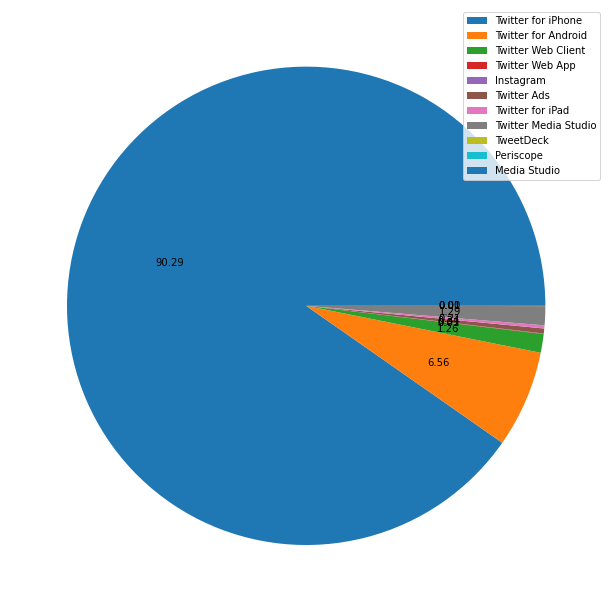

In [15]:
percent = np.zeros(len(sources))
for source in tw['device']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

labels = sources
plt.figure(figsize=(11,11))
plt.pie(percent,autopct='%.2f')
plt.legend(labels, loc="best")
plt.axis("off")
plt.show()

## NLP Analysis

### 1. N-Gram Analysis (NLTK)
Starting from here, we finally enter the field of Natural Language Processing. NLP lets us use computational technique to analyze sentences in human languages in order to get a specific outcome. It has already been applied in our daily life including the predictive function on smartphone keyboards and AI search result suggestions. 

The first NLP tool we use is the [NLTK](https://www.nltk.org/) package. It's one of the strongest python package in NLP, providing various functions. We use it to performe a simple word lemmatization. Then the sentences are split into words.

In [16]:
def w_process(text):
  wnl = nltk.stem.WordNetLemmatizer()
  sw = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in sw]

We further define several functions that are useful for N-Gram analysis. N-Gram analysis is also a function provided by NLTK package.

Basically, N-Gram is a contiguous sequence of n words from a given sentences. An N-Gram model can predict the occurrence of a word based on the occurrence of its N – 1 previous words.

For this analysis, we will use self_tw which only consist of Trump's original tweets.

In [17]:
def w_take(df, col):
    """
    Takes in a dataframe and columns
    Rreturns a list of words that have been processed
    """
    return w_process(''.join(str(df[col].tolist())))

def bi_grams(df, col):
    """
    Takes in a list of words
    Returns a series of 10 top used bigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(w_take(df, col), 2)).value_counts())[:10]

def bg_vis(df ,col):
    
    # Visualization of the Bi-Gram series
    
    bi_grams(df, col).sort_values().plot.barh(width=.9, figsize=(12, 8))
    plt.title("10 Most Frequently Used Bigrams")
    plt.ylabel("Bigram")
    plt.xlabel("Occurances")

def tri_grams(df, col):
    """
    Takes in a list of words
    Returns a series of 10 top used trigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(w_take(df, col), 3)).value_counts())[:10]

def tg_vis(df, col):
    
    # Visualization of the Tri-Gram series
    
    tri_grams(df, col).sort_values().plot.barh(color="orange", width=.9, figsize=(12, 8))
    plt.title("10 Most Frequently Used Trigrams")
    plt.ylabel("Trigram")
    plt.xlabel("Occurances")

In [18]:
bi_grams(self_tw, "text")

(fake, news)            882
(united, state)         523
(america, great)        419
(make, america)         380
(crooked, hillary)      377
(witch, hunt)           365
(white, house)          320
(new, york)             301
(hillary, clinton)      294
(total, endorsement)    284
dtype: int64

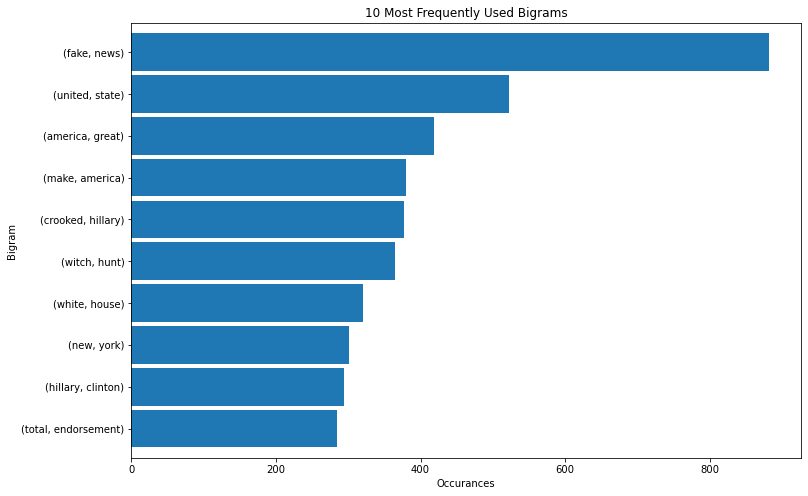

In [19]:
bg_vis(self_tw, "text")

In [20]:
tri_grams(self_tw, "text")

(make, america, great)            329
(fake, news, medium)              231
(complete, total, endorsement)    222
(crooked, hillary, clinton)       136
(new, york, time)                  92
(sleepy, joe, biden)               86
(radical, left, democrat)          65
(kim, jong, un)                    61
(strong, crime, border)            60
(law, amp, order)                  53
dtype: int64

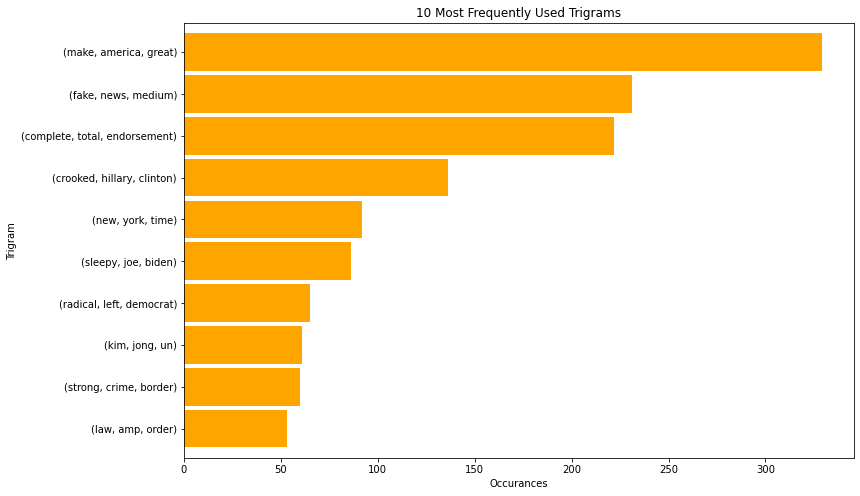

In [21]:
tg_vis(self_tw, "text")

### 2. Sentiment Analysis (TextBlob)

People express their opinions on Twitter and these usually have sentiment associated with them. The next NLP analysis we are gonna do is called "Sentiment Analysis", which categorizes the tweet as either positive, negative or neutral. Sentiment analysis may show people's attitude towards a topic and lead to some useful insight.

Although NLTK is a very powerful tool, this time we are gonna switch to something simpler and easier to use. [TextBlob](https://textblob.readthedocs.io/en/dev/) is a simplified text processing tool that can help determine the sentiment of a sentence by parsing through and giving it a score between -1 and 1. A negative number means negative sentiment, while a positive number simply means positive sentiment. It's totally possible that the machine may give an incorrect sentiment for tricky words like "high poverty rate". A well trained model may have less possibility on doing such things.

When exploring some interesting topics with machine learning, sentiment score becomes a useful indicator that can potentially drive correlation between result and attitudes. In the following code, we let python performe sentiment analysis for each of the tweets and give a score based on that. A subjectivity test will also be done. Furthermore, a new column will be made indicating the polarity of each tweet.

In [22]:
def sa_polarity(tweet):
    if tb(tweet).sentiment.polarity > 0:
        return "Positive"
    elif tb(tweet).sentiment.polarity ==0:
        return "Neutral"
    else:
        return "Negative"
    
self_tw["Polarity"] = np.array([sa_polarity(tweet) for tweet in self_tw['text']])
self_tw["Sentiment score"] = np.array([tb(tweet).sentiment.polarity for tweet in self_tw['text']])
self_tw["Subjectivity score"] = np.array([tb(tweet).sentiment.subjectivity for tweet in self_tw['text']])

c:\software\coding\python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\software\coding\python\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\software\coding\python\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [23]:
self_tw.head()

,text,isRetweet,device,favorites,retweets,date,Polarity,Sentiment score,Subjectivity score
41318,Join us CaucusForTrump11am WATERLOO CEDER RAPIDS,f,Twitter for iPhone,4167,1640,2016-02-01 02:51:22,Neutral,0.000000,0.000000
41317,It all begins today WE WILL FINALLY TAKE OUR C...,f,Twitter for Android,17571,7105,2016-02-01 13:25:20,Positive,0.266667,0.583333
41314,My experience in Iowa was a great one I starte...,f,Twitter for Android,16820,4340,2016-02-02 16:03:21,Positive,0.466667,0.583333
41313,Because I was told I could not do well in Iowa...,f,Twitter for Android,12001,3325,2016-02-02 16:14:24,Positive,0.177917,0.446667
41312,The media has not covered my long shot great f...,f,Twitter for Android,10045,3030,2016-02-02 16:29:05,Positive,0.290000,0.560000


In [24]:
print("The percentage of each Polarity in all tweets:")
self_tw["Polarity"].value_counts(normalize = True)

The percentage of each Polarity in all tweets:


Positive    0.524386
Neutral     0.258857
Negative    0.216757
Name: Polarity, dtype: float64

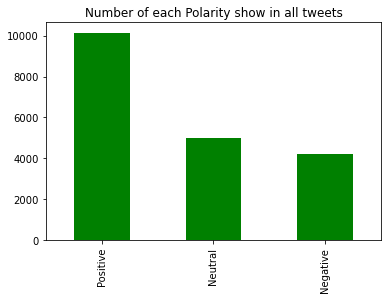

In [25]:
self_tw["Polarity"].value_counts().plot.bar(color="green")
plt.title("Number of each Polarity show in all tweets")
plt.show()

### 3. Tableau Data Visualization
The next step we are gonna do is to put both polarity score and subjectivity score into one line chart. To do that, we can simply group the date by month and plot it with matplotlib. However, we want to go a little further by allowing user to choose the specific time periods they are looking at and also see the entire trails on time series analysis.

Thus, I want to introduce a new visualization tool called [Tableau](https://www.tableau.com/). Tableau is a leading industrial data visualization tool that can help organize, analyze and visualize datas. In this project, I'm using it to create a motion chart that allows reader to choose which periods of date they want to look at. By clicking on the play button, it shows animation of time flow with all the trails.

To do that, we first save the dataset to a csv file.

In [26]:
self_tw.to_csv("trump_tweets_sentiment.csv")

After that, we will be using Tableau Desktop to create the visualization we need. After creating the workbook, it is then published to Tableau Online server. The server will generate an embeded url that can be integrated in Jupyter Notebook.

(Tableau Online server requires a paid subscription. Please let me know if the following integration stop showing up.)

In [27]:
%%HTML
<script type='text/javascript' src='https://us-west-2b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 956px; height: 905px;'><object class='tableauViz' width='956' height='905' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-west-2b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;dlfenganalytics' /><param name='name' value='Trump_Tweets_Sentiment&#47;trump_tweet_sentiment_motion&#47;dinglujamesfeng@gmail.com&#47;f720f162-7010-4f7a-b5bc-55bd3b6d2196' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

## Stock Market Analysis
### 1. Data Collection 
Many evidences have showed that Trump's Twitter has constantly impacting stock market performance. As a development of this project, we want to find the corrrelation between the stock market trend and the setiment score of Trump's post.

The first step is to scrap some financial data from the internet. Here we use a convenient python package called [YFinance](https://pypi.org/project/yfinance/). It helps get all the historical financial data from Yahoo Finance. Since we are learning about the general stock market performance, we will use S&P500 Market index in the project.

Because we are using a market index, the dividends and stock split column are dropped. Date are corped from 2016-02-01 to 2019-11-06 to match the date from the Trump_Twitter dataset.

In [28]:
sp500 = yf.Ticker("^GSPC")
sp_data_raw = sp500.history(start="2016-02-01", end="2020-11-06")
spd = sp_data_raw.drop(["Dividends", "Stock Splits"],axis=1)
spd.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-02-01,1936.939941,1947.199951,1920.300049,1939.380005,4322530000
2016-02-02,1935.260010,1935.260010,1897.290039,1903.030029,4463190000
2016-02-03,1907.069946,1918.010010,1872.229980,1912.530029,5172950000
2016-02-04,1911.670044,1927.349976,1900.520020,1915.449951,5193320000
2016-02-05,1913.069946,1913.069946,1872.650024,1880.050049,4929940000


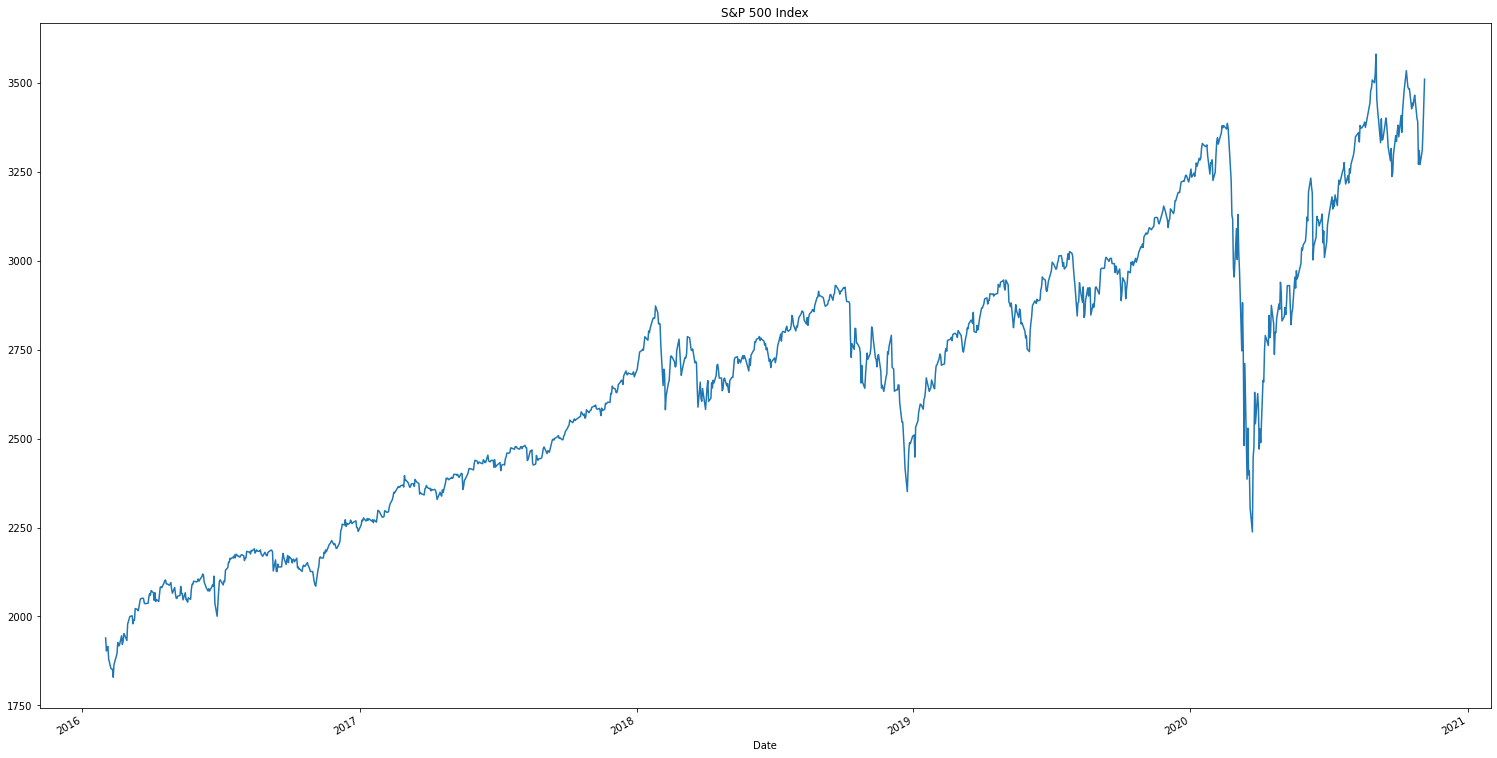

In [29]:
plt.figure(figsize=(26,14))
plt.title("S&P 500 Index")
spd["Close"].plot()
plt.show()

In order to bettwe analyze the date, we set date as index and drop all the time info. Pivot table is used to group data by dates.

In [30]:
stock_self_tw = self_tw
stock_self_tw["Date"] = pd.to_datetime(stock_self_tw["date"]).dt.normalize()
stock_self_tw = stock_self_tw.set_index("Date")
stock_self_tw

c:\software\coding\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,isRetweet,device,favorites,retweets,date,Polarity,Sentiment score,Subjectivity score
Date,,,,,,,,,
2016-02-01,Join us CaucusForTrump11am WATERLOO CEDER RAPIDS,f,Twitter for iPhone,4167,1640,2016-02-01 02:51:22,Neutral,0.000000,0.000000
2016-02-01,It all begins today WE WILL FINALLY TAKE OUR C...,f,Twitter for Android,17571,7105,2016-02-01 13:25:20,Positive,0.266667,0.583333
2016-02-02,My experience in Iowa was a great one I starte...,f,Twitter for Android,16820,4340,2016-02-02 16:03:21,Positive,0.466667,0.583333
2016-02-02,Because I was told I could not do well in Iowa...,f,Twitter for Android,12001,3325,2016-02-02 16:14:24,Positive,0.177917,0.446667
2016-02-02,The media has not covered my long shot great f...,f,Twitter for Android,10045,3030,2016-02-02 16:29:05,Positive,0.290000,0.560000
...,...,...,...,...,...,...,...,...,...
2020-11-06,Legislature They just ignored that ignored the...,f,Twitter for iPhone,53553,13287,2020-11-06 16:28:41,Negative,-0.718519,0.762963
2020-11-06,has been able to render decisions in a matter ...,f,Twitter for iPhone,102067,19257,2020-11-06 16:28:42,Positive,0.166667,0.250000
2020-11-06,hopefully this will be corrected at the Suprem...,f,Twitter for iPhone,113524,22224,2020-11-06 16:28:42,Negative,-0.093333,0.520000


In [31]:
sst_pivot = pd.pivot_table(stock_self_tw, index=["Date"])
sst_pivot

,Sentiment score,Subjectivity score,favorites,retweets
Date,,,,
2016-02-01,0.133333,0.291667,10869.000000,4372.500000
2016-02-02,0.212101,0.499332,8796.076923,2410.230769
2016-02-03,0.096147,0.465947,7452.571429,3117.571429
2016-02-04,0.202096,0.394949,6843.111111,2589.666667
2016-02-05,0.245540,0.354824,4670.363636,1532.000000
...,...,...,...,...
2020-11-02,0.096167,0.265612,96158.095238,16774.555556
2020-11-03,0.121411,0.276376,160251.555556,27420.583333
2020-11-04,-0.061832,0.431648,307925.076923,52766.923077


In [32]:
comb_stock = pd.merge(sst_pivot, spd, how="left", on="Date")
comb_stock

,Sentiment score,Subjectivity score,favorites,retweets,Open,High,Low,Close,Volume
Date,,,,,,,,,
2016-02-01,0.133333,0.291667,10869.000000,4372.500000,1936.939941,1947.199951,1920.300049,1939.380005,4.322530e+09
2016-02-02,0.212101,0.499332,8796.076923,2410.230769,1935.260010,1935.260010,1897.290039,1903.030029,4.463190e+09
2016-02-03,0.096147,0.465947,7452.571429,3117.571429,1907.069946,1918.010010,1872.229980,1912.530029,5.172950e+09
2016-02-04,0.202096,0.394949,6843.111111,2589.666667,1911.670044,1927.349976,1900.520020,1915.449951,5.193320e+09
2016-02-05,0.245540,0.354824,4670.363636,1532.000000,1913.069946,1913.069946,1872.650024,1880.050049,4.929940e+09
...,...,...,...,...,...,...,...,...,...
2020-11-02,0.096167,0.265612,96158.095238,16774.555556,3296.199951,3330.139893,3279.739990,3310.239990,4.310590e+09
2020-11-03,0.121411,0.276376,160251.555556,27420.583333,3336.250000,3389.489990,3336.250000,3369.159912,4.220070e+09
2020-11-04,-0.061832,0.431648,307925.076923,52766.923077,3406.459961,3486.250000,3405.169922,3443.439941,4.783040e+09


### 2. Model
I intend to use random forest and XGBoost to construct a machine learning model in exporing the correlation among the stock market performance and Trump's tweets' sentiment score.

Unfortunatelly, the first draft of the model is under my expectation with overfitting issue. As the due date approach, I decide to make it as a continuation project. I will keep using the above dataset on developing this model and update the newest version on github.

In [33]:
X = comb_stock.iloc[0:20, 0:1].values
y = comb_stock.iloc[0:20, 7:8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Reference
Shreyas, P. (2020, June 06). Tweet analytics using NLP. Retrieved December 22, 2020, 

    from https://medium.com/analytics-vidhya/tweet-analytics-using-nlp-f83b9f7f7349

Thomas, N. (2020, October 24). Covfefe &amp; NLP - Do Trump's tweets move the Stock Market? Retrieved December 22, 2020, 

    from https://towardsdatascience.com/covfefe-nlp-do-trumps-tweets-move-the-stock-market-42a83ab17fea

Trump, D. (n.d.). Donald Trump's Twitter.

    from https://twitter.com/realDonaldTrump?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor

R. Ferro, Pandas Twitter, (2017), GitHub repository

    from https://github.com/RodolfoFerro/pandas_twitter